# Regularization of linear regression model

In this notebook, we show the **limitations of simple linear regression** models and
the **advantage of using regularized** models instead.

Besides, we present the **preprocessing required** when dealing
with regularized models, furthermore when the **regularization parameter**
needs to be **tuned**.

We start by highlighting the **over-fitting issue** that can arise in
a simple linear regression model with **too many (engineered) features**.

## Effect of regularization

We first load the California housing dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescale the target in k$
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


## Linear regression + Polynomial feature set augmentation

In one of the earlier notebooks, we show that **linear models could be used**
even in settings **where `data` and `target`** are **not linearly *link*ed**. Specificially, the **`PolynomialFeatures` transformer** creates
additional features encoding **non-linear *interactions* between features**.

Here, we use this **transformer** again **to augment the feature space**, then
train a linear regression model and use the
**out-of-sample test set** to **evaluate the generalization capabilities** of our
model.

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(PolynomialFeatures(degree=2),
                                  LinearRegression())
cv_results = cross_validate(linear_regression, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

We compare the **mean squared error** on the **training** and **test set** to
assess the **generalization performance** of our model:

In [3]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4190.212 +/- 151.123


In [4]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
13334.943 +/- 20292.679


The score on the test set is much worse than on the training set and this **statistical performance gap between the training and test score** is an indication that our **model
overfits** our training set.

Indeed, one of the **dangers of augmenting** the **feature set**
with a **`PolynomialFeatures` transformer** is that our **model will zoom in on some
specific features while leaving others out**. We put the weights in a box plot and **check the weights of the model** to have a better view of this effect. 

`PolynomialFeatures` creates feature names representative of the feature 
combinations and one can access them with the **`get_feature_names` method**. 
First, let's get the first fitted model from the cross-validation to get the feature names.

In [5]:
model_first_fold = cv_results["estimator"][0]
model_first_fold

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

Now, we can access the fitted `PolynomialFeatures` to **get the feature
names**.

In [6]:
feature_names = model_first_fold[0].get_feature_names(
    input_features=data.columns)
feature_names

C:\Users\R21\anaconda3\envs\dl\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['1',
 'MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'MedInc^2',
 'MedInc HouseAge',
 'MedInc AveRooms',
 'MedInc AveBedrms',
 'MedInc Population',
 'MedInc AveOccup',
 'MedInc Latitude',
 'MedInc Longitude',
 'HouseAge^2',
 'HouseAge AveRooms',
 'HouseAge AveBedrms',
 'HouseAge Population',
 'HouseAge AveOccup',
 'HouseAge Latitude',
 'HouseAge Longitude',
 'AveRooms^2',
 'AveRooms AveBedrms',
 'AveRooms Population',
 'AveRooms AveOccup',
 'AveRooms Latitude',
 'AveRooms Longitude',
 'AveBedrms^2',
 'AveBedrms Population',
 'AveBedrms AveOccup',
 'AveBedrms Latitude',
 'AveBedrms Longitude',
 'Population^2',
 'Population AveOccup',
 'Population Latitude',
 'Population Longitude',
 'AveOccup^2',
 'AveOccup Latitude',
 'AveOccup Longitude',
 'Latitude^2',
 'Latitude Longitude',
 'Longitude^2']

Let's construct a dataframe with the **weights for each feature** vs **each** of the 10 **cv bucket**.

In [7]:
import pandas as pd

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_linear_regression = pd.DataFrame(coefs, columns=feature_names)
weights_linear_regression

,1,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc^2,...,Population^2,Population AveOccup,Population Latitude,Population Longitude,AveOccup^2,AveOccup Latitude,AveOccup Longitude,Latitude^2,Latitude Longitude,Longitude^2
0,0.000020,-1140.478055,-98.735399,738.891265,-3694.264431,0.026004,119.975984,797.604954,602.115764,-3.350467,...,2.723368e-07,0.001898,0.002020,0.001252,0.009463,2.124956,1.801719,5.105701,9.521863,3.843453
1,0.000008,-1052.152444,-86.839209,634.803005,-3400.011369,-0.018349,279.105936,793.917970,405.165061,-3.177068,...,2.902987e-07,0.001441,0.001231,0.000569,0.015912,3.987531,3.653011,4.869199,9.361477,3.007598
2,0.000005,-1047.784040,-81.454227,566.113358,-2807.775407,0.040838,110.895680,964.710028,805.906156,-2.622063,...,3.059134e-07,0.001709,0.002302,0.001462,0.008302,1.967116,1.658570,6.592902,11.868451,5.076783
3,0.000005,-1191.834869,-91.891841,608.442806,-2977.418828,0.029125,125.399166,848.204536,541.626680,-3.221603,...,2.939818e-07,0.001828,0.002244,0.001362,0.008057,2.094999,1.815240,6.317023,10.662395,3.758923
4,0.000006,-1068.457292,-77.972733,742.832110,-3570.586749,0.060562,18.297959,985.426360,781.002571,-2.857276,...,-1.065777e-07,0.004502,0.002481,0.001733,0.002640,2.191904,0.839418,6.439938,11.955237,4.978589
5,0.000004,-1210.378962,-82.487009,728.530449,-3462.706081,0.037991,85.811905,866.808452,652.236175,-3.339029,...,2.098276e-07,0.002003,0.001870,0.001317,0.008350,2.167047,1.523408,5.485767,10.312099,4.171595
6,0.000005,-1129.973409,-88.006378,566.637551,-2543.679764,0.036381,58.800131,762.223877,521.400605,-3.331669,...,3.215231e-07,0.001389,0.002351,0.001484,0.015151,1.991793,1.192665,5.924855,9.724632,3.547843
7,0.000005,-1069.471716,-55.601936,491.194897,-2270.967198,0.120629,183.993455,664.776982,346.916861,-3.048110,...,4.484090e-07,0.002208,0.003271,0.002441,0.011466,2.054016,2.336563,6.235422,9.218651,2.805173
8,0.000019,-1079.167003,-75.047701,617.640991,-3160.787045,0.127525,53.394723,1400.403508,952.670096,-2.639377,...,3.249388e-07,0.001795,0.003525,0.002562,0.008983,2.023151,1.187022,9.873007,17.548444,6.562120
9,0.000007,-1224.686290,-101.440489,767.987598,-3608.689097,-0.069552,273.822755,834.810790,463.591709,-3.508383,...,1.837084e-07,0.002156,0.001040,0.000177,0.002651,3.676339,3.494053,6.309539,10.560549,3.419154


Now, **boxplot** the **coefficients variations**:

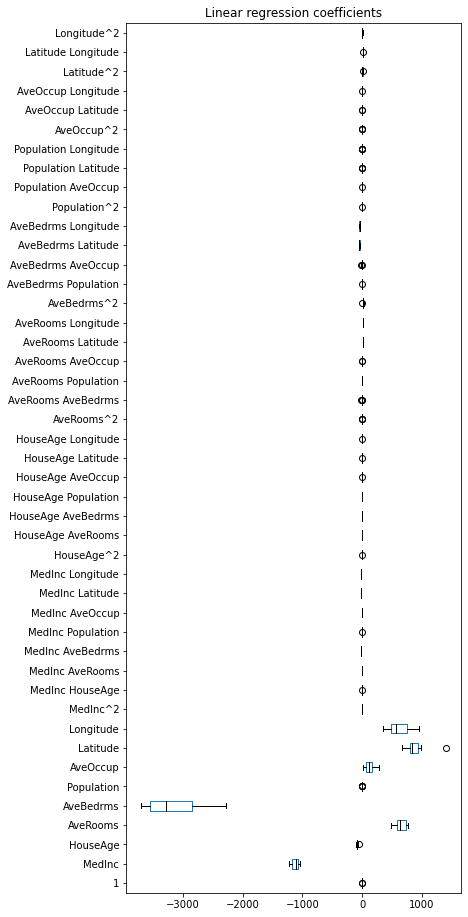

In [8]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_linear_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Linear regression coefficients")

Though we add the non-linear and interaction terms, the model does not put significant weights on them. The model zooms in on only six linear features, hence the large gap in the MSE between the training set and test set.

## Linear regression + L2 regularization + Polynomial feature set augmentation

We can force the linear regression model to consider all features in a more
homogeneous manner. In fact, we could **force** large positive or negative **weights**
to **shrink toward zero**. This technique is known as **regularization**. We apply the **ridge** model with the `alpha` regularization parameter to enforces this behavior. The regularization parameter `alpha` is an important hyperparameter as we will see later.

In [9]:
from sklearn.linear_model import Ridge

ridge = make_pipeline(PolynomialFeatures(degree=2),
                      Ridge(alpha=100))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

C:\Users\R21\anaconda3\envs\dl\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.672e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\R21\anaconda3\envs\dl\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.67257e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\R21\anaconda3\envs\dl\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.75536e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\R21\anaconda3\envs\dl\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.67367e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\R21\anaconda3\envs\dl\lib\site-packages\sklearn\linea

In [10]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regresion model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regresion model on the train set:
4373.180 +/- 153.942


In [11]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regresion model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regresion model on the test set:
7303.589 +/- 4950.732


The training and test scores are much closer for this regularized model then the above non-regularized one, indicating that regularized model is **less overfitting**. Let's boxplot the values of the weights of the
ridge regression so that we can compare with those of the un-regularized linear regression before.

In [12]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

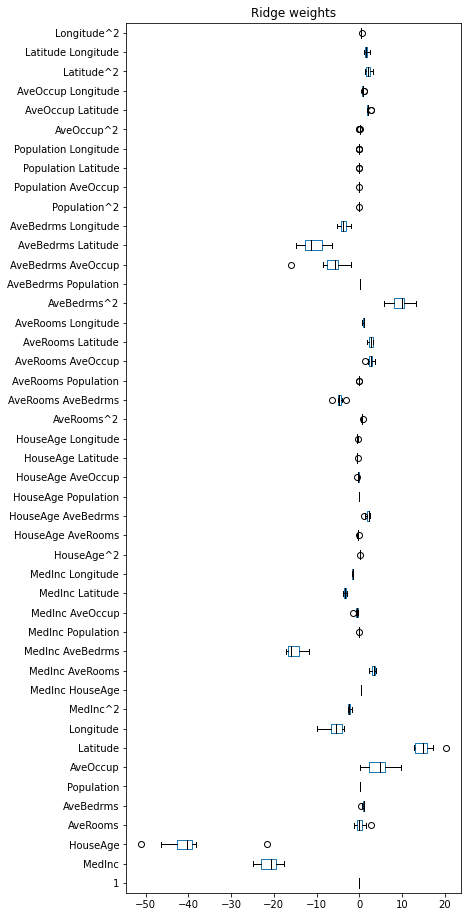

In [13]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights")

By comparing the magnitude of the weights in this boxplot with the
boxplot of the simple linear regression above, we see that the **magnitude of the weights are shrunk towards zero**.

However, in this example, we are still omitting two important aspects: (i) the need to
**scale the data** and (ii) the need to **search for the best regularization
parameter**.

## Scale your data!

Regularization adds constraints on weights of the model as we see it in the
previous above. The ridge regression model enforces that all **weights** have a
similar **magnitude**. Indeed, the **larger `alpha`**, the **larger this enforcement**.

This procedure should make us **think** about **feature rescaling**, so let's consider
the case where features have an identical data dispersion. This is also called **whitening of the data**. After whitening, if two features are found equally important by the model, they will be affected similarly by regularization strength.

Now, let's consider **a scenario** with **two features** having completely different
data dispersion. For instance age in years has a **low dispersion** ranging in ~0 to ~100 and annual revenue in dollars with a **high dispersion** ranging 0 to the millions.
**If** these **two features** are **equally important**, our **regularization model** will **boost the weights of the feature with low dispersion** and **reduce the weights of the feature with high dispersion**.

We recall that regularization forces weights to be closer. Therefore, we get
an intuition that if we want to use regularization, dealing with rescaled
data would make it easier to find an optimal regularization parameter and
thus an adequate model.

As a **pactical side note**, **optimizers** based on **gradient computation** (e.g. gradient descent (GD), stochastic gradient descent (SGD)) are **expecting** such
**rescaled data**. **Unscaled data will be detrimental** when computing the optimal
weights. Therefore, when working with a linear model and numerical data, it
is generally good practice to scale the data.

Thus, we add a `StandardScaler` to our machine learning pipeline, which we place just before the regressor so that the Ridge regressor see a scaled dataset.

In [14]:
from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      Ridge(alpha=0.5))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [15]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4347.036 +/- 156.666


In [16]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
5508.472 +/- 1816.642


Note that the test error is now much closer to the training error, so our model is **significantly less overfitted**. We are getting closer to the best generalization sweet spot.

Let's take a look at the weights again.

In [17]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

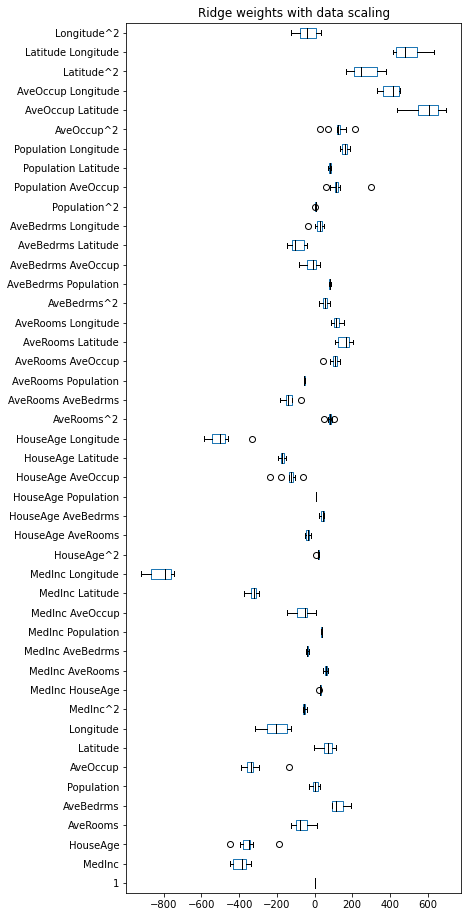

In [18]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights with data scaling")

Compare to the previous plots, we see that now **all weight manitudes are
closer to zero** and that all weights are **more equally contributing**.

So far in the analysis the `alpha` parameter has been fixed.

In the following section, we look into the **impact of the `alpha` hyperparameter** and **fine tune it**.

## Fine tuning the regularization parameter

The regularization parameter needs to be tuned on each dataset to find the optimal model. So let's **tune the `alpha` parameter**.

Model hyperparameter tuning should be done with care. Indeed, we want to
find an **optimal parameter value** that **maximizes some metrics**. Thus, it requires both
a training set and test set.

However, this test set should be different from the out-of-sample test
set that we use to evaluate our model: if we use the same one, we are using
an `alpha` which was optimized for this test set and it breaks the
out-of-sample rule.

We need an outer and an inner cross-validation. We should nest an inner cross-validation for the search of the hyperparameter `alpha` within the outer
cross-validation. We split the data into test and validation sets in the outer cross-validation and on a given fold's validation set we run the inner cross-validation to find the optimal `alpha`. As we saw in previous notebooks, we could use a
grid-search. However, some predictor in **scikit-learn** are available with
an **integrated hyperparameter search**, more efficient than using a grid-search.
The names of these predictors end in `CV`. In the case of `Ridge`,
scikit-learn provides a **`RidgeCV` regressor**.

We use the `RidgeCV` predictor as the last step of the pipeline for inner cross-validation.  The **inner cross-validation** **searches for the best
alpha**, while the **outer cross-validation** gives an estimate of the
test score with that best `alpha` for that outer cross-validation fold.

In [19]:
import numpy as np
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-2, 0, num=20)
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      RidgeCV(alphas=alphas, store_cv_values=True))

In [20]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(ridge, data, target,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=-1)

In [21]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4306.562 +/- 25.918


In [22]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
4348.657 +/- 252.921


By optimizing `alpha`, we see that the **training** an **test scores** are really **close** to one another. It indicates that our **model is not overfitting**.

### MSE vs `alpha`



When fitting and cross-validating the ridge regressor, we store the test error of the inner cross-validation (by setting the parameter `store_cv_values=True`).
We plot the mean of the MSE over the outer folds across the `alpha` regularization
strengths. Let's create a dataframe: the column names are the `alpha`s while the row names indicate the outer cross-validation fold and the values in the table are the MSE for a given fold's given (not necessarily best) `alpha`.

In [23]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)
              for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas).transform('sqrt')
cv_alphas

,0.010000,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.784760,1.000000
0,87.108537,84.021017,81.115946,78.497386,76.243350,74.399934,72.983877,71.992712,71.419528,71.268595,71.568355,72.378893,73.791049,75.914506,78.853823,82.675717,87.376725,92.863449,98.954123,105.401499
1,84.138824,81.832891,79.555153,77.380406,75.374439,73.587851,72.054708,70.796957,69.833950,69.195190,68.933676,69.136486,69.928087,71.460875,73.888762,77.325809,81.801779,87.232917,93.421678,100.085428
2,157.662318,146.452329,135.253386,124.422703,114.311119,105.220992,97.367539,90.853902,85.667753,81.700835,78.784671,76.730315,75.360890,74.531294,74.135361,74.103763,74.396072,74.989319,75.864723,76.994509
3,86.626884,84.410155,82.183776,80.006249,77.929057,75.993038,74.229075,72.663799,71.329939,70.279953,69.600489,69.423469,69.927168,71.319146,73.796188,77.487553,82.402147,88.404252,95.228897,102.527749
4,83.665637,81.233606,78.837577,76.559314,74.471644,72.631791,71.079878,69.843689,68.949002,68.433304,68.359710,68.827048,69.970959,71.950423,74.916624,78.968588,84.109746,90.223633,97.079716,104.366435


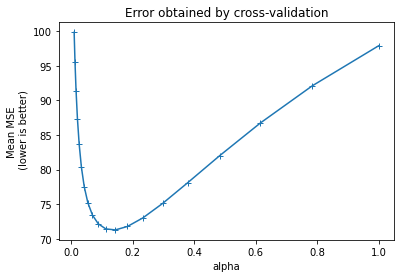

In [24]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean MSE\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

The best `alpha` is around 0.14.

### Stability of best `alpha` across cv folds

As we can see, regularization is just like salt in cooking: one must balance
its amount to get the best statistical performance. We can check if the **best
`alpha`** found is **stable across the 5 cross-validation folds**.

In [25]:
best_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
best_alphas

[0.08858667904100823,
 0.11288378916846889,
 0.37926901907322497,
 0.14384498882876628,
 0.11288378916846889]

### Pick best `alpha` manually

By playing around with `alpha`, its best value is 0.29.

Mean squared error of linear regression model on the train set:
4309.976 +/- 155.291
Mean squared error of linear regression model on the test set:
5286.343 +/- 1805.537


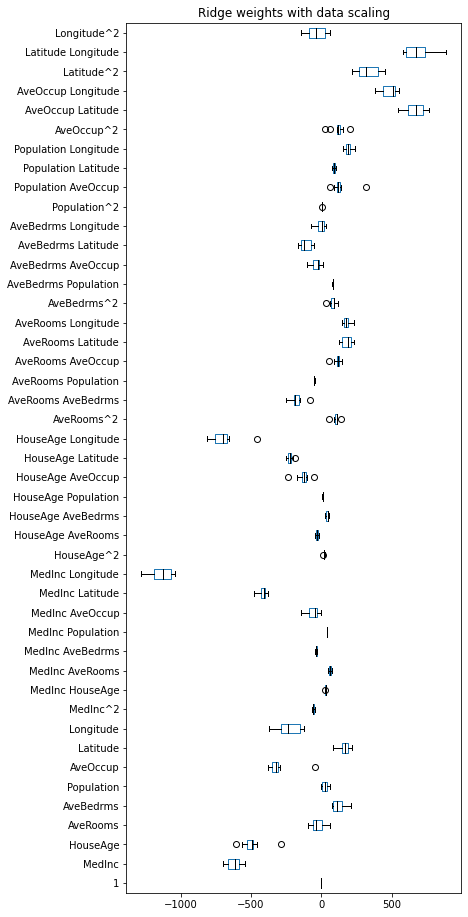

In [26]:
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      Ridge(alpha=0.29))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)
                            
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights with data scaling")

In this notebook, you learned about the concept of **regularization** and
the **importance of preprocessing** and **parameter tuning**.